## Estimate Home Values in Zillow

Faith Kane
10/18/2019

### Goals:

1. Use the fips numbers in the Zillow database to identify the locations of the properties I am examining.

2. Use the tax amounts and actual home values to calculate and visualize the distribution of tax rates for each county I identify in my data. 

3. Build a linear regression model that predicts home values using three features: bedroom count, bathroom count, and square feet.

4. Evaluate and compare the metrics from my train and test models to a baseline model that predicts home values using only the mean of all home values. I will use the $R2$ values of the models to decide if my linear regression model with the three identified features from above is able to make more accurate predictions.



### Import Modules:

In [34]:
import csv
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score

from math import sqrt
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


import env
import util
import wrangle_zillow
import split_scale_zillow
import features_zillow
import model_zillow
import explore_zillow
import explore
import evaluate

#### Read In, Clean, and Transform the Data Using wrangle_zillow()

-My function, wrangle_zillow, uses the SQL query I created to bring in data from the Zillow database, drop rows containing Null values, and set my columns to the appropriate data types.

-My SQL query filtered the Zillow data to include only single unit residential properties whose last transactions were in the months of May and June in 2017. I also filtered out any rows that had a value of zero for bedroomcnt or bathroomcnt which gave me a row count of 15,947.

-I adjusted my SQL query to filter out any rows that had a value below one or above six for bedrooms or a value below one or above five for bathrooms which gave me a total of 15,722 rows to work with in my models. I based my decision for the upper bounds on bedrooms and bathrooms on the equation Q3 + 1.5 * IQR. However, when I ran my models, the $R^2$ scores went down by more than ten percent, so I decided to leave in the outliers and use my original SQL query from above.

In [11]:
df = wrangle_zillow.wrangle_zillow()

In [12]:
df.head()

,bedrooms,bathrooms,square_feet,taxes,home_value,propertylandusedesc,fips_number,zip_code
0,4.0,2.0,1604,6089.82,498347.0,Single Family Residential,6037,96415.0
1,3.0,3.0,2384,6679.55,549917.0,Single Family Residential,6037,96452.0
2,3.0,2.0,1574,3876.31,235272.0,Single Family Residential,6037,97319.0
3,2.0,2.0,1619,4206.15,340000.0,Single Family Residential,6037,97329.0
4,2.0,3.0,2408,24353.42,2017254.0,Single Family Residential,6037,96086.0


#### Summarize the Data Using tell_me_about(df)

-My function, tell_me_about(df), allows me to view important descriptive information about my data before I begin to work with it. 

In [5]:
util.tell_me_about(df)

DataFrame Shape:

(15947, 8)

Info about:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15947 entries, 0 to 15955
Data columns (total 8 columns):
bedrooms               15947 non-null float64
bathrooms              15947 non-null float64
square_feet            15947 non-null int64
taxes                  15947 non-null float64
home_value             15947 non-null float64
propertylandusedesc    15947 non-null category
fips_number            15947 non-null int64
zip_code               15947 non-null category
dtypes: category(2), float64(4), int64(2)
memory usage: 931.8 KB
None

Describe:

           bedrooms     bathrooms   square_feet          taxes    home_value  \
count  15947.000000  15947.000000  15947.000000   15947.000000  1.594700e+04   
mean       3.253026      2.215213   1836.276729    5680.471976  4.632920e+05   
std        0.949431      1.025248    980.727638    7466.513817  6.434062e+05   
min        1.000000      1.000000    320.000000      49.180000  1.216800e+04   
2

#### Create a Field that Calculates the Tax Rate:

In [16]:
df["tax_rate"] = df["taxes"] / df["home_value"]
df.head()

,bedrooms,bathrooms,square_feet,taxes,home_value,propertylandusedesc,fips_number,zip_code,tax_rate
0,4.0,2.0,1604,6089.82,498347.0,Single Family Residential,6037,96415.0,0.012220
1,3.0,3.0,2384,6679.55,549917.0,Single Family Residential,6037,96452.0,0.012146
2,3.0,2.0,1574,3876.31,235272.0,Single Family Residential,6037,97319.0,0.016476
3,2.0,2.0,1619,4206.15,340000.0,Single Family Residential,6037,97329.0,0.012371
4,2.0,3.0,2408,24353.42,2017254.0,Single Family Residential,6037,96086.0,0.012073


#### Add the county name to the DataFrame based on the fips number.

In [17]:
df["county_name"] = df["fips_number"].map({6037: "Los Angeles", 6059: "Orange", 6111: "Ventura"})
df.head()

,bedrooms,bathrooms,square_feet,taxes,home_value,propertylandusedesc,fips_number,zip_code,tax_rate,county_name
0,4.0,2.0,1604,6089.82,498347.0,Single Family Residential,6037,96415.0,0.012220,Los Angeles
1,3.0,3.0,2384,6679.55,549917.0,Single Family Residential,6037,96452.0,0.012146,Los Angeles
2,3.0,2.0,1574,3876.31,235272.0,Single Family Residential,6037,97319.0,0.016476,Los Angeles
3,2.0,2.0,1619,4206.15,340000.0,Single Family Residential,6037,97329.0,0.012371,Los Angeles
4,2.0,3.0,2408,24353.42,2017254.0,Single Family Residential,6037,96086.0,0.012073,Los Angeles


In [18]:
df.to_csv('zillow.csv')

#### Create Distributions of the Tax Rates by County:

-I found the breakdown of fips_numbers at the USDA government site:

https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
    
-Using the fips_numbers, I found that all three counties represented in my data are in the state of California; they are Los Angeles County, Orange County, and Ventura County.

-I created dataframes to display the mean tax_rate for each county as well as the count of properties in each county.

In [19]:
county_mean_tax_rate = pd.DataFrame(df.groupby("county_name").tax_rate.mean())
county_mean_tax_rate

,tax_rate
county_name,
Los Angeles,0.013735
Orange,0.012111
Ventura,0.011499


In [20]:
county_count = pd.DataFrame(df.groupby("county_name").county_name.count())
county_count

,county_name
county_name,
Los Angeles,12382
Orange,2778
Ventura,787


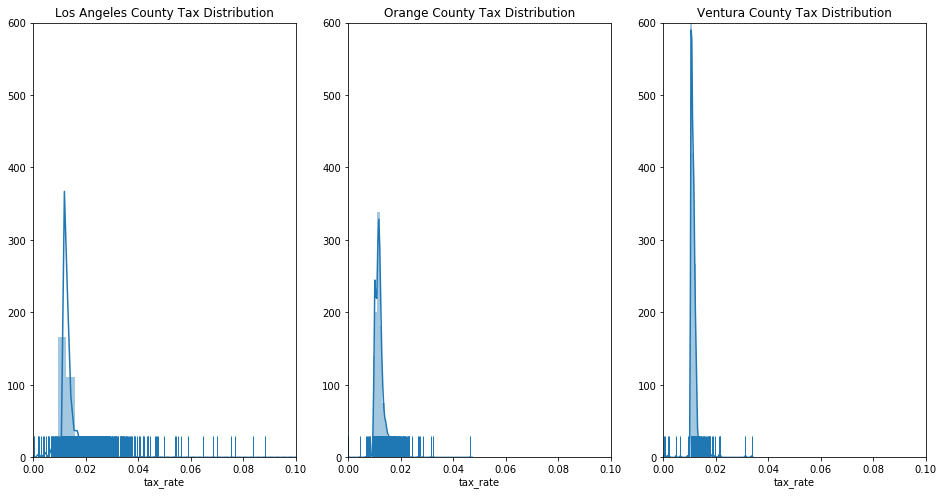

In [21]:
los_angeles_tax_dist = df[df.county_name == "Los Angeles"].tax_rate
orange_tax_dist = df[df.county_name == "Orange"].tax_rate
ventura_tax_dist = df[df.county_name == "Ventura"].tax_rate

plt.figure(figsize=(16,8))

plt.subplot(1,3,1)
sns.distplot(los_angeles_tax_dist, bins=50, kde=True, rug=True)
plt.xlim(0, .10)
plt.ylim(0, 600)
plt.title("Los Angeles County Tax Distribution")

plt.subplot(1,3,2)
sns.distplot(orange_tax_dist, bins=50, kde=True, rug=True)
plt.xlim(0, .10)
plt.ylim(0, 600)
plt.title("Orange County Tax Distribution")

plt.subplot(1,3,3)
sns.distplot(ventura_tax_dist, bins=50, kde=True, rug=True)
plt.xlim(0, .10)
plt.ylim(0, 600)
plt.title("Ventura County Tax Distribution")

plt.show()

#### Split the Data Using split_my_data(df) and Assign Features (x) and Target (y)

-I split my data using a function I created that creates a train set using 80% of the data and a test set using 20%. I used the random seed "123" in splitting my data.

-The features I am using to predict "taxvaluedollarcnt"in my x_train and x_test dataframes are the "bedroomcnt", "bathroomcnt", and "calculatedfinishedsquarefeet" fields from the Zillow database.

-The features I am using to predict "taxvaluedollarcnt" in my sbd_train and sbd_test dataframes are "calculatedfinishedsquarefeet" and "bedroomcnt" from the Zillow database.

--The features I am using to predict "taxvaluedollarcnt" in my sbt_train and sbt_test dataframes are "calculatedfinishedsquarefeet" and "bathroomcnt" from the Zillow database.

In [22]:
train, test = split_scale_zillow.split_my_data(df)

#####  Assign x_train x_test to the three features of bedrooms, bathrooms, and square feet and y_train and y_test to the target of home_value

In [23]:
X_train = train[["bedrooms", "bathrooms", "square_feet"]]
y_train = train[["home_value"]]
X_test = test[["bedrooms", "bathrooms", "square_feet"]]
y_test = test[["home_value"]]

#####  Assign sbd_train sbd_test to the features of square feet and bedrooms

In [24]:
sbd_X_train = train[["square_feet", "bedrooms"]]
sbd_X_test = test[["square_feet", "bedrooms"]]

#####  Assign sbt_train sbt_test to the features of square feet and bathrooms

In [25]:
sbt_X_train = train[["square_feet", "bathrooms"]]
sbt_X_test = test[["square_feet", "bathrooms"]]

#### Scale the Data Using the IQR Robust Scaler

-I used the iqr_robust_scaler to scale my x_train and x_test, sbd_train and sbd_test, and sbt_train and sbt_test data because it scales features using stats that are robust to outliers by removing the median and scaling data to the IQR.

-I will use these scaled data sets when I get into feature selection. I will create my model using the features that return the highest $R^2$ scores from my Recursive Feature Elimination function.

In [29]:
scaler, X_train_scaled, X_test_scaled = split_scale_zillow.iqr_robust_scaler(X_train, X_test)

In [30]:
sbd_scaler, sbd_X_train_scaled, sbd_X_test_scaled = split_scale_zillow.iqr_robust_scaler(sbd_X_train, sbd_X_test)

In [31]:
sbt_scaler, sbt_X_train_scaled, sbt_X_test_scaled = split_scale_zillow.iqr_robust_scaler(sbt_X_train, sbt_X_test)

#### Explore the Data: 

-I used a Pair Grid Plots to visualize the relationships between features. The plot compares relationships between the features along with the regression line.

-I used a heatmap with annotations to see the correlations between different features and the target value. Taxes is almost a perfect correlation, but that would be using a feature that was calculated using the target to predict the target, or in other words, using the future to predict the future. That is not an eligible feature to make predictions.

-The highest correlation is between square_feet and home_value at .64. The second highest is between bathrooms and home_value at .54 and third highest between bedrooms and home_value at .28. Those are the three features I will use to predict the target of home_value.

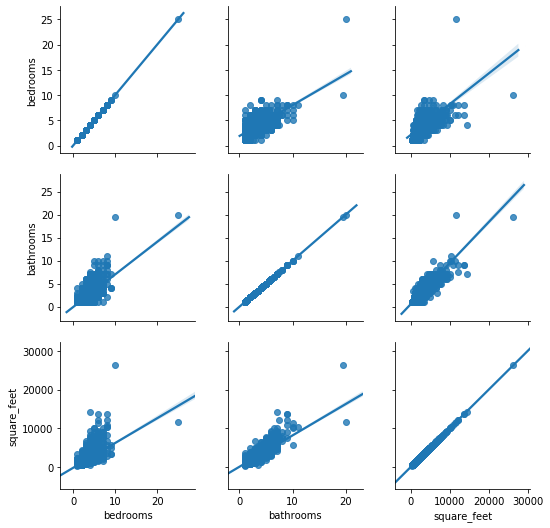

In [38]:
explore_zillow.plot_variable_pairs(X_train)

#### Correlation Test:

-I created a heat map and computed pairwise correlation of the columns in my dataframe.

-The heatmap shows what the chart below it displays. 

(0, 7)

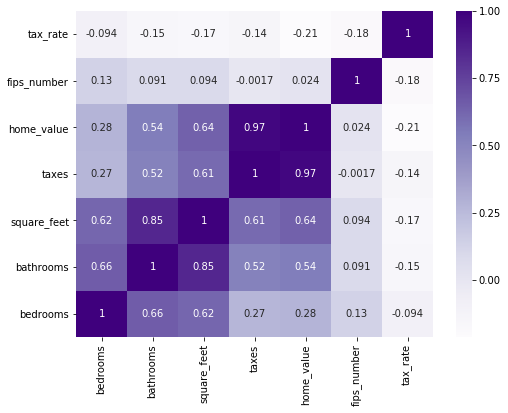

In [42]:
plt.figure(figsize=(8,6))
sns.heatmap(train.corr(), cmap='Purples', annot=True)
plt.ylim(0, 7)

In [47]:
df.corr().style.background_gradient(cmap='YlOrRd')

,bedrooms,bathrooms,square_feet,taxes,home_value,fips_number,tax_rate
bedrooms,1,0.657402,0.621797,0.272215,0.279147,0.130339,-0.0909345
bathrooms,0.657402,1,0.846623,0.519509,0.53553,0.0884696,-0.149872
square_feet,0.621797,0.846623,1,0.611819,0.638991,0.0929851,-0.162766
taxes,0.272215,0.519509,0.611819,1,0.977952,-0.00764505,-0.143307
home_value,0.279147,0.53553,0.638991,0.977952,1,0.0180586,-0.208675
fips_number,0.130339,0.0884696,0.0929851,-0.00764505,0.0180586,1,-0.177635
tax_rate,-0.0909345,-0.149872,-0.162766,-0.143307,-0.208675,-0.177635,1


In [48]:
#pd.crosstab(train.bedrooms, train.bathrooms).style.background_gradient(cmap='YlOrRd')

#### Summary Metrics including T-Test

Train data

In [20]:
ols_model = sm.OLS(y_train, x_train_scaled).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             home_value   R-squared (uncentered):                   0.425
Model:                            OLS   Adj. R-squared (uncentered):              0.425
Method:                 Least Squares   F-statistic:                              3143.
Date:                Sun, 20 Oct 2019   Prob (F-statistic):                        0.00
Time:                        23:05:13   Log-Likelihood:                     -1.8777e+05
No. Observations:               12757   AIC:                                  3.756e+05
Df Residuals:                   12754   BIC:                                  3.756e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
bedrooms    -7.121e+04   7389.844     -9.636      0.000   -8.57e+04   -5.67e+04
bathrooms    1.217e+04   1.03e+04      1.188      0.235   -7918.957    3.23e+04
square_feet  4.952e+05   9465.578     52.314      0.000    4.77e+05    5.14e+05
==============================================================================
Omnibus:                    16139.417   Durbin-Watson:                   1.332
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8778428.488
Skew:                           6.491   Prob(JB):                         0.00
Kurtosis:                     130.853   Cond. No.                         4.07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
R2, p_value = evaluate.model_significance(ols_model)
print(f"R2 = {R2}")
print(f"p_value = {p_value}")

R2 = 0.4250609371600932
p_value = 0.0


Test data

In [22]:
ols_model_test = sm.OLS(y_test, x_test_scaled).fit()
ols_model_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             home_value   R-squared (uncentered):                   0.408
Model:                            OLS   Adj. R-squared (uncentered):              0.407
Method:                 Least Squares   F-statistic:                              732.0
Date:                Sun, 20 Oct 2019   Prob (F-statistic):                        0.00
Time:                        23:05:13   Log-Likelihood:                         -47100.
No. Observations:                3190   AIC:                                  9.421e+04
Df Residuals:                    3187   BIC:                                  9.422e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
bedrooms    -5.904e+04   1.58e+04     -3.748      0.000   -8.99e+04   -2.82e+04
bathrooms    1.232e+04   2.09e+04      0.588      0.556   -2.87e+04    5.34e+04
square_feet  4.976e+05   1.91e+04     26.077      0.000     4.6e+05    5.35e+05
==============================================================================
Omnibus:                     4641.668   Durbin-Watson:                   1.405
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4321550.635
Skew:                           8.212   Prob(JB):                         0.00
Kurtosis:                     182.565   Cond. No.                         3.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
R2_test, p_value_test = evaluate.model_significance(ols_model_test)
print(f"R2 = {R2}")
print(f"p_value = {p_value}")

R2 = 0.4250609371600932
p_value = 0.0


#### Feature Selection:

-I used my function optimal_number_of_features function to find out the optimal number of features to feed into my Linear Regression model and the $R^2$ value using those features. The recommendation was that the three features together would predict my target value with a $R^2$ of .4406.

-Using the three features together rather than the other combinations I tried below, square_feet and bathrooms or square_feet and bedrooms, returned the highest $R^2$ value, and thus is the combination of features I will use in my Linear Regression model to predict home values.


In [24]:
features_zillow.optimal_number_of_features(x_train_scaled, y_train)

(3, 0.4406039047470966)

In [25]:
features_zillow.optimal_number_of_features(sbd_train_scaled, y_train)

(2, 0.4393605165369422)

In [26]:
features_zillow.optimal_number_of_features(sbt_train_scaled, y_train)

(2, 0.4160258684955639)

#### Model:  Create Linear Regression Models Using modeling_function()

-I used my modeling_function() to create a dataframe containing the actual home values, the predictions made by my Linear Regression Model 1, lm1, that used the original three features of bedrooms (bedroomcnt), bathrooms (bathroomcnt), and square_feet (calculatedfinishedsquarefeet) to predict the target home values (taxvaluedollarcnt), and the baseline or mean of all target home values.

-I ran my Linear Regression Model with the test set of my data, lm1_test, that predicted the target home values in the same manner as above. I created a predictions_test DataFrame that holds the actual home values from my test set, the predictions, and the baseline.

In [27]:
predictions, predictions_test = model_zillow.modeling_function(x_train_scaled, y_train, x_test_scaled, y_test)

predictions.head()

,actual,lm1,lm_baseline
0,1252995.0,885428.134588,461061.036921
1,192960.0,279014.832467,461061.036921
2,616795.0,753196.413153,461061.036921
3,470103.0,631875.015836,461061.036921
4,361585.0,310014.300220,461061.036921


In [28]:
yhat = predictions.lm1
y = predictions.actual

In [29]:
SSE, ESS, TSS, MSE, RMSE = evaluate.regression_errors(y, yhat)
print(f"SSE for model = {SSE}")
print(f"ESS for model = {ESS}")
print(f"TSS for model = {TSS}")
print(f"MSE for model = {MSE}")
print(f"RMSE for model = {RMSE}")


SSE for model = 2912289275936049.0
ESS for model = 2293841586703243.0
TSS for model = 5206130862639292.0
MSE for model = 228289509754.3348
RMSE for model = 477796.51500857016


In [30]:
yhat_test = predictions_test.lm1_test
y_test = predictions_test.actual

In [31]:
tSSE, tESS, tTSS, tMSE, tRMSE = evaluate.regression_errors(y_test, yhat_test)
print(f"tSSE for test model = {tSSE}")
print(f"tESS for test model = {tESS}")
print(f"tTSS for test model = {tTSS}")
print(f"tMSE for test model = {tMSE}")
print(f"tRMSE for test model = {tRMSE}")

tSSE for test model = 832673056345532.6
tESS for test model = 562069527578663.06
tTSS for test model = 1394742583924195.8
tMSE for test model = 261026036471.9538
tRMSE for test model = 510907.07224695355


#### Evaluate:  Compare Model Performance Metrics

The Baseline Model Evaluation Metrics:

-The baseline model evaluation reveals an $R^2$ value of 0. I will use this value to compare with the $R^2$ values of my train and test linear regression models below. I want to find out if the models can predict home values better than just using the mean of all the home values.

In [32]:
bMSE = mean_squared_error(predictions.actual, predictions.lm_baseline)
bSSE = bMSE*len(predictions.actual)
bRMSE = sqrt(bMSE)
br2 = r2_score(predictions.actual, predictions.lm_baseline)
baseline_metrics_df = pd.DataFrame(np.array(["bMSE", "bSSE","bRMSE", "bR2"]), columns=["metric"])
baseline_metrics_df["value"] = np.array([bMSE, bSSE, bRMSE, br2])
baseline_metrics_df

,metric,value
0,bMSE,4.080999e+11
1,bSSE,5.206131e+15
2,bRMSE,6.388270e+05
3,bR2,0.000000e+00


Text(0.5, 1.0, 'Model Predictions vs Actual Predictions')

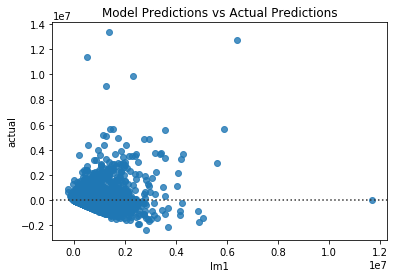

In [70]:
sns.residplot(predictions.lm1, predictions.actual)
plt.title("Model Predictions vs Actual Predictions")

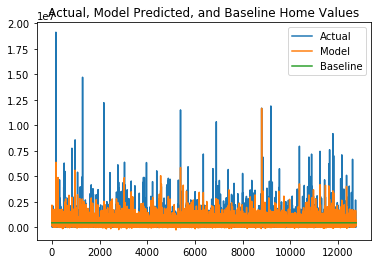

In [83]:
plt.title("Actual, Model Predicted, and Baseline Home Values")
sns.lineplot(data=predictions.actual, label="Actual")
sns.lineplot(data=predictions.lm1, label="Model")
sns.lineplot(data=predictions.lm_baseline, label="Baseline")

The Linear Regression Models' Evaluation Metrics:

-The Linear Regression model including bedrooms, bathrooms, and square_feet as features returned a $R^2$ value of .4406 for the train data set and .4029 for the test data set.


In [66]:
MSE_1= mean_squared_error(predictions.actual, predictions.lm1)
SSE_1 = MSE_1*len(predictions.actual)
RMSE_1 = sqrt(MSE_1)
r2_1 = r2_score(predictions.actual, predictions.lm1)
print(MSE_1,SSE_1,RMSE_1,r2_1)


228289509754.3348 2912289275936049.0 477796.51500857016 0.44060390474709654


In [67]:
MSE_lm1_test = mean_squared_error(predictions_test.actual, predictions_test.lm1_test)
SSE_lm1_test = MSE_lm1_test*len(predictions_test.actual)
RMSE_lm1_test = sqrt(MSE_lm1_test)
r2_lm1_test = r2_score(predictions_test.actual, predictions_test.lm1_test)
print(MSE_lm1_test,SSE_lm1_test,RMSE_lm1_test,r2_lm1_test)


261026036471.9538 832673056345532.6 510907.07224695355 0.40299158716244654


#### Side-by-Side Comparison of Model Evaluation Metrics:

In [68]:
df_eval = pd.DataFrame(np.array(["SSE","MSE","RMSE", "R2"]), columns=["metric"])
df_eval["model_1_error"] = np.array([SSE_1, MSE_1, RMSE_1, r2_1])
df_eval["baseline_error"] = np.array([bSSE, bMSE, bRMSE, br2])
df_eval["error_delta_1"] = df_eval.model_1_error - df_eval.baseline_error
df_eval

,metric,model_1_error,baseline_error,error_delta_1
0,SSE,2.912289e+15,5.206131e+15,-2.293842e+15
1,MSE,2.282895e+11,4.080999e+11,-1.798104e+11
2,RMSE,4.777965e+05,6.388270e+05,-1.610305e+05
3,R2,4.406039e-01,0.000000e+00,4.406039e-01


In [69]:
df_eval_test = pd.DataFrame(np.array(["SSE","MSE","RMSE", "R2"]), columns=["metric"])
df_eval_test["lm1_test_error"] = np.array([SSE_lm1_test, MSE_lm1_test, RMSE_lm1_test, r2_lm1_test])
df_eval_test["baseline_error"] = np.array([bSSE, bMSE, bRMSE, br2])
df_eval_test["error_delta_lm1_test"] = df_eval_test.lm1_test_error - df_eval_test.baseline_error

df_eval_test

,metric,lm1_test_error,baseline_error,error_delta_lm1_test
0,SSE,8.326731e+14,5.206131e+15,-4.373458e+15
1,MSE,2.610260e+11,4.080999e+11,-1.470739e+11
2,RMSE,5.109071e+05,6.388270e+05,-1.279199e+05
3,R2,4.029916e-01,0.000000e+00,4.029916e-01
